# fMRI Demo (nilearn version)

## Introduction

This is an example of RSA on a BIDS-structured fMRI dataset. This study is still under review, so we will update this demo to include steps to download the data when it becomes publicly available. 

Participants (n=14) viewed images of 16 objects, as well as their written name. Several properties of the stimuli were carefully balanced. They also performed several tasks, but for the purposes of this demo we will ignore these.

![stimuli](demo_fmri_files/mur32_stims.png)

This library depends on *nibabel* for convenience functions to access MRI data, and is used separately in the demo as well, so start by installing nibabel (`pip install nibabel`).

Then run the following imports:

In [1]:
%matplotlib inline
from os.path import expanduser
from rsatoolbox.io.fmriprep import find_fmriprep_runs, make_design_matrix
from rsatoolbox.data.dataset import Dataset, merge_datasets
from rsatoolbox.rdm.rdms import concat
from rsatoolbox.vis import show_rdm
from rsatoolbox.rdm.calc import calc_rdm
from rsatoolbox.data.noise import prec_from_residuals
import numpy, pandas, matplotlib.pyplot
import nilearn, nibabel

Now we define the path to the BIDS-root data directory

In [2]:
data_dir = expanduser('~/data/rsatoolbox/mur32')

Next we use a utility function to find the relevant preprocessed BOLD images:

In [3]:
runs = find_fmriprep_runs(data_dir, tasks=['main'])
len(runs)

84

As with most real-world datasets, this one has some unplanned idiosyncrasies; subject 02 is missing some data, and to keep this demo straightforward, we will remove subject 02 from the analysis:

In [4]:
runs = [run for run in runs if run.boldFile.sub != '02']
len(runs)

78

Each run object carries the relevant data and metadata

In [5]:
run = runs[0]
run

<FmriprepRun [sub-01/ses-01/func/sub-01_ses-01_task-main_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz]>

In [6]:
dims = run.get_data(masked=True).shape ## bold timeseries: x * y * z * volumes
n_vols = dims[-1]
dims

(59944, 546)

Access the attributes stored in the *_metadata.json* for this file

In [7]:
tr = run.get_meta()['RepetitionTime'] ## TR in seconds
tr

2

We will also load the events table

In [8]:
run.get_events().sample(5) ## 5 random events

,onset,duration,trial_type,modality,identity,response_time,task,response_mapping
94,281.990,0.500,baseline,NaN,NaN,NaN,NaN,NaN
15,44.984,0.500,text_brick,text,brick,0.691,fixation,right-left
59,176.984,0.500,baseline,NaN,NaN,NaN,NaN,NaN
273,818.993,1.501,instruction,NaN,NaN,NaN,NaN,NaN
345,1034.991,0.500,image_sponge,image,sponge,0.755,verbal,right-left


In [9]:
run.get_confounds().head(3)

,global_signal,csf,white_matter,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,531.491645,689.191863,529.250888,-0.114997,0.014836,0.121413,-0.011220,0.001374,-0.003820
1,530.925851,678.949631,529.508515,-0.086089,0.002786,0.080875,-0.014051,0.000906,-0.004132
2,529.247373,676.817258,529.533116,-0.093505,0.052070,0.113270,-0.012427,0.001203,-0.004285


## Patterns

Next we want to establish Multi-Voxel Patterns from the timeseries, such that, for each stimulus presentation, we have one observation per voxel. The most common way to do this is with a General Linear Model, where each predictor in the model reflects one type of event, convolved with the haemodynamic response function (HRF). For the purposes of this demo we will use a very basic glm implementation in Python. For a guide on MVPA, see [Mur et al. 2009](https://doi.org/10.1093/scan/nsn044).

First we use a utility function which creates predictors from the events table and convolves them with the HRF. Note that we have 34 predictors, with a value for each volume in the BOLD timeseries. 

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: identity, response_mapping, response_time, task, modality
  warnings.warn(


<Axes: label='conditions', ylabel='scan number'>

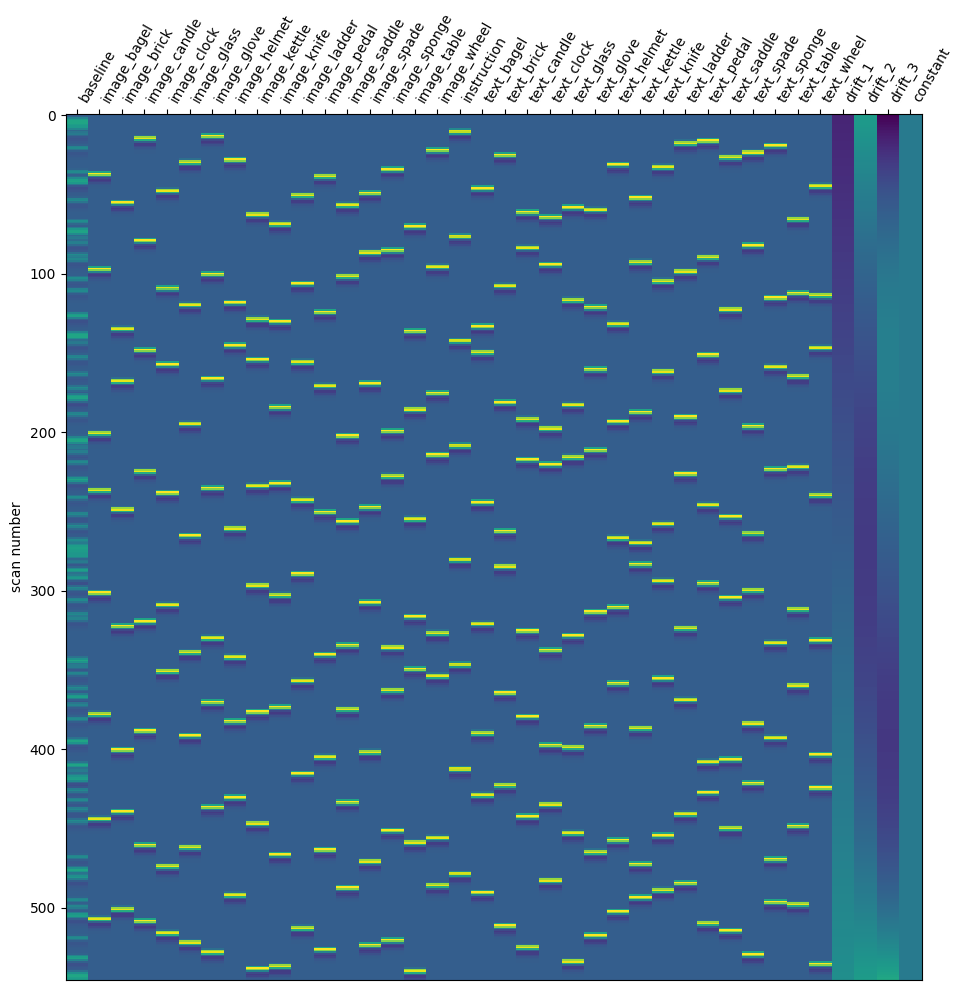

In [10]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

frame_times = numpy.linspace(0, tr*(n_vols-1), n_vols) ## [0, 2, 4] onsets of scans in seconds
design_matrix = make_first_level_design_matrix(frame_times, run.get_events(),
    drift_model='polynomial', drift_order=3)
plot_design_matrix(design_matrix)

This plot shows the design matrix. Every blip reflects the haemodynamic response to a single trial.

### GLM
Here we fit nilearn's implementation of the GLM (~1minute)

In [11]:
from nilearn.glm.first_level import FirstLevelModel
mask_fpath = run.boldFile.get_mri_sibling(desc='brain', suffix='mask').fpath
glm = FirstLevelModel(
    t_r=2.0,
    mask_img=False,
    minimize_memory=False,
    signal_scaling=False,
)
glm.fit([run.boldFile.fpath], design_matrices=design_matrix)

FirstLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x340756510>,
                minimize_memory=False, signal_scaling=False, t_r=2.0)

In [12]:
conditions = [c for c in design_matrix.columns if ('image_' in c) or ('text_' in c)]
conditions

['image_bagel',
 'image_brick',
 'image_candle',
 'image_clock',
 'image_glass',
 'image_glove',
 'image_helmet',
 'image_kettle',
 'image_knife',
 'image_ladder',
 'image_pedal',
 'image_saddle',
 'image_spade',
 'image_sponge',
 'image_table',
 'image_wheel',
 'text_bagel',
 'text_brick',
 'text_candle',
 'text_clock',
 'text_glass',
 'text_glove',
 'text_helmet',
 'text_kettle',
 'text_knife',
 'text_ladder',
 'text_pedal',
 'text_saddle',
 'text_spade',
 'text_sponge',
 'text_table',
 'text_wheel']

In [13]:
contrast_val = ['image_glove - baseline']
z_map = glm.compute_contrast(contrast_val, output_type='z_score')

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


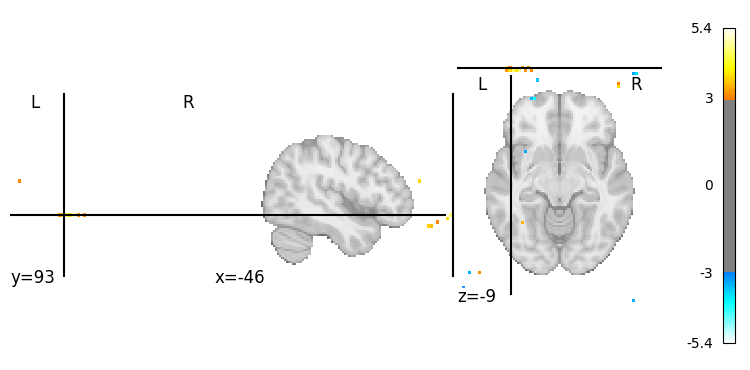

In [14]:
from nilearn.plotting import plot_stat_map
plot_stat_map(z_map, threshold=3) # bg_img=mean_img

Explain mask

In [16]:
mask_img = nibabel.load('ctx-rh-inferiortemporal.nii.gz')
it_mask = mask_img.get_fdata().astype(bool)
it_mask.sum()
it_mask.shape
z_map.get_fdata().shape


(65, 77, 55)

In [16]:
it_pattern = z_map.get_fdata()[it_mask]
numpy.count_nonzero(it_pattern)
it_pattern.size

181

Let's have a look at the Region-of-Interest (ROI)

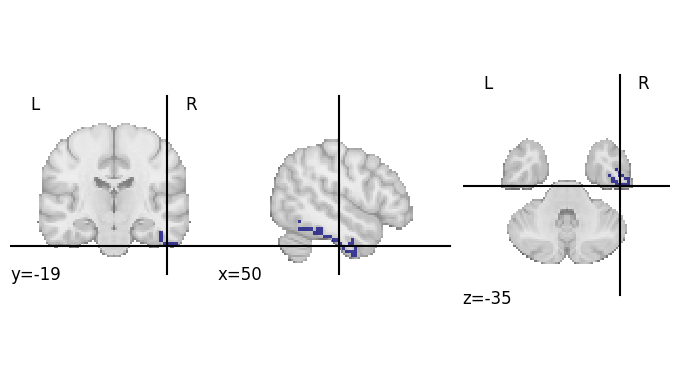

In [17]:
from nilearn.plotting import plot_roi
plot_roi(mask_img)

In [18]:
glm.residuals[0].get_fdata()[it_mask].shape

(181, 546)

In [19]:
it_pattern = z_map.get_fdata()[it_mask]
it_pattern.shape

(181,)

When we apply this to the first run we get the following pattern array

The run object then provides us with dictionaries with attributes that identify this run and its various dimensions. These map unto the rsatoolbox *descriptors*.

In [20]:
run.to_descriptors(collapse_by_trial_type=True)

{'descriptors': {'sub': '13', 'ses': '02', 'run': '03', 'task': 'main'},
 'obs_descriptors': {'trial_type': array(['baseline', 'instruction', 'text_candle', 'text_kettle',
         'image_candle', 'text_knife', 'text_glove', 'text_table',
         'image_ladder', 'text_wheel', 'text_saddle', 'text_clock',
         'text_glass', 'text_bagel', 'image_clock', 'image_table',
         'image_knife', 'image_brick', 'image_bagel', 'image_wheel',
         'text_ladder', 'image_pedal', 'text_brick', 'text_pedal',
         'text_spade', 'image_helmet', 'image_glass', 'text_sponge',
         'text_helmet', 'image_glove', 'image_spade', 'image_sponge',
         'image_kettle', 'image_saddle'], dtype=object)},
 'channel_descriptors': {'aparcaseg': array(['Unknown', 'Unknown', 'Unknown', ..., 'Unknown', 'Unknown',
         'Unknown'], dtype=object)}}

We can then combine the patterns and descriptors to create an rsatoolbox `Dataset` object

In [21]:
Dataset(
    measurements=numpy.atleast_2d(it_pattern),
    descriptors=run.get_dataset_descriptors(),
    obs_descriptors=dict(trial_type=['image_glove']),
)

rsatoolbox.data.Dataset(
measurements = 
[[ 0.13949706  0.79139454 -0.39352596  0.24619856  1.41331719 -0.39166516
  -0.6627188   0.76387042  0.80520777 -0.6616972   0.76300663  0.67231396
   0.0192077  -0.05191981  0.42027833  0.65663842 -1.09095028  0.47946837
  -1.21186421 -0.47275761 -0.13844362 -0.05837482 -0.82365821  0.20326502
   0.32445705 -0.95925567  0.32697089 -0.12168187 -0.00773631  0.17753782
  -0.31230022 -0.51902356 -0.04270238 -0.53285006 -0.78219082 -1.1685363
  -0.98705936 -1.30841505 -0.35620877 -0.66884773  0.91224939 -0.21030627
   0.98846075  1.08808296  1.0851289   0.42533147 -0.90861411 -0.26403255
   0.33714761  0.53254223  1.1148457  -1.31656043 -0.77419024  0.17251126
   0.73560877 -0.44687454 -0.26385924  0.59621542 -0.43031829  0.27732623
  -0.26424241  0.03977764 -0.79091367 -2.50920363 -0.8091895  -0.53129729
  -0.68723918 -1.75481311 -0.6894918   0.92153812  0.42120292 -0.0188953
  -0.44815652 -1.26365304 -1.58724344 -0.08698974 -0.30200561  0.45032373

Let's repeat this for the other runs: (takes about 1min per run). Along the way we also store the MSE residuals for each run.

In [22]:
run_datasets = []
run_noise_sets = []

for run in runs:
    design_matrix = make_first_level_design_matrix(
        frame_times,
        run.get_events(),
        drift_model='polynomial',
        drift_order=3
    )
    glm = FirstLevelModel( ## necessary to redefine this? docs do not say if fit is idempotent
        t_r=2.0,
        mask_img=False,
        minimize_memory=False,
        signal_scaling=False,
    )
    glm.fit([run.boldFile.fpath], design_matrices=design_matrix)
    
    patterns = []
    for cond in conditions:
        z_map = glm.compute_contrast(f'{cond} - baseline', output_type='z_score')
        patterns.append(z_map.get_fdata()[it_mask])

    run_datasets.append(
        Dataset(
            measurements=numpy.asarray(patterns),
            descriptors=run.get_dataset_descriptors(),
            obs_descriptors=dict(trial_type=conditions),
        )
    )

    run_noise_sets.append(
        Dataset(
            measurements=glm.residuals[0].get_fdata()[it_mask].T,
            descriptors=run.get_dataset_descriptors(),
        )
    )
len(run_datasets)

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: response_time, identity, modality, task, response_mapping
  warnings.warn(
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0

18

In [41]:
run_datasets[0].measurements.shape

(32, 181)

In [26]:
run_datasets[0].obs_descriptors

{'trial_type': ['image_bagel',
  'image_brick',
  'image_candle',
  'image_clock',
  'image_glass',
  'image_glove',
  'image_helmet',
  'image_kettle',
  'image_knife',
  'image_ladder',
  'image_pedal',
  'image_saddle',
  'image_spade',
  'image_sponge',
  'image_table',
  'image_wheel',
  'text_bagel',
  'text_brick',
  'text_candle',
  'text_clock',
  'text_glass',
  'text_glove',
  'text_helmet',
  'text_kettle',
  'text_knife',
  'text_ladder',
  'text_pedal',
  'text_saddle',
  'text_spade',
  'text_sponge',
  'text_table',
  'text_wheel']}

## Calculate data RDMs

Let's remove the *baseline* and *instruction* conditions as they are not relevant for our RSA approach:

Next we focus on a ROI: The right hemisphere IT as provided by the cortical parcellation *aparc*

Calculate the noise precision (with shrinkage) matrix for each run

In [27]:
degrees_of_freedom = design_matrix.shape[1]
display(degrees_of_freedom)

38

In [28]:
run_noise_sets[0].measurements.shape

(546, 181)

In [29]:
run_precs = []
for nds in run_noise_sets:
    run_precs.append(
        prec_from_residuals(
            nds.measurements,
            dof=degrees_of_freedom,
            method='shrinkage_diag'
        )
    )

Then pass this list to `calc_rdm` to compute the mahalanobis dissimilarity:

In [51]:
group_ds = merge_datasets(run_datasets)
group_ds.obs_descriptors.keys()

dict_keys(['trial_type', 'ses', 'sub', 'run'])

In [49]:
run_datasets[0].descriptors

{'sub': '13', 'ses': '02', 'run': '03', 'task': 'main'}

Loop over subjects and calculate an RDM. (Without having to index the noise this could be done without a loop)

In [54]:
rdms_list = []
for sub in set(group_ds.obs_descriptors['sub']):
    run_indices = [r for (r, ds) in enumerate(run_datasets) if ds.descriptors['sub'] == sub]
    rdms_list.append(
        calc_rdm(
            dataset=merge_datasets([run_datasets[r] for r in run_indices]),
            noise=[run_precs[r] for r in run_indices],
            method='crossnobis',
            descriptor='trial_type',
            cv_descriptor='run',
        )
    )
data_rdms = concat(rdms_list)

[6, 7, 8, 9, 10, 11]

[12, 13, 14, 15, 16, 17]

[0, 1, 2, 3, 4, 5]

Let's plot the participant RDMs.

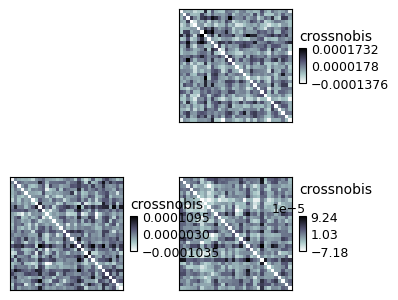

In [56]:
fig, _, _ = show_rdm(data_rdms, show_colorbar='panel')
matplotlib.pyplot.show()

## Model

Let's map the various stimulus properties of interest on a table

In [35]:
a_ds = run_datasets[0]
obj_conds = numpy.unique(a_ds.obs_descriptors['trial_type']).tolist()
INDOOR = ['bagel', 'candle', 'clock', 'glass', 'kettle', 'knife', 'sponge', 'table']
STRAIGHT = ['candle', 'knife', 'sponge', 'table', 'spade', 'ladder', 'brick', 'pedal']
df = pandas.DataFrame([dict(
    trial_type=c,
    indoor=float(c.split('_')[1] in INDOOR),
    straight=float(c.split('_')[1] in STRAIGHT),
    modality=float('image_' in c)
) for c in obj_conds])
df

,trial_type,indoor,straight,modality
0,image_bagel,1.0,0.0,1.0
1,image_brick,0.0,1.0,1.0
2,image_candle,1.0,1.0,1.0
3,image_clock,1.0,0.0,1.0
4,image_glass,1.0,0.0,1.0
5,image_glove,0.0,0.0,1.0
6,image_helmet,0.0,0.0,1.0
7,image_kettle,1.0,0.0,1.0
8,image_knife,1.0,1.0,1.0
9,image_ladder,0.0,1.0,1.0


We can then turn these into Model RDMs

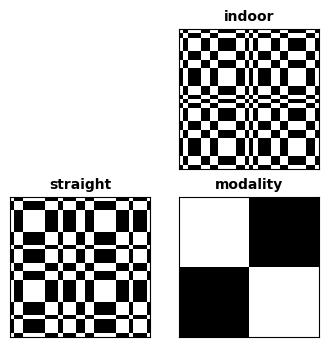

In [36]:
model_dataset = Dataset.from_df(df)
model_dataset.channel_descriptors
model_rdms = calc_rdm(
    [model_dataset.split_channel('name')],
    method='euclidean',
    descriptor='trial_type'
)
model_rdms.rdm_descriptors['name'] = model_dataset.channel_descriptors['name']
fig, _, _ = show_rdm(model_rdms, rdm_descriptor='name')
matplotlib.pyplot.show()

Next, we wrap each of the model RDMs in their own fixed `Model` object.

In [37]:
from rsatoolbox.model.model import ModelFixed

models = []
for model_name in model_rdms.rdm_descriptors['name']:
    model_rdm = model_rdms.subset('name', model_name)
    models.append(ModelFixed(model_name, model_rdm))

## Inference

Let's see how well each of these models explains the fMRI data RDMs

In [57]:
from rsatoolbox.inference.evaluate import eval_dual_bootstrap

eval_result = eval_dual_bootstrap(models, data_rdms)
print(eval_result)

100%|██████████| 1000/1000 [00:03<00:00, 295.24it/s]

Results for running dual_bootstrap evaluation for cosine on 3 models:

Model    |   Eval ± SEM   | p (against 0) | p (against NC) |
------------------------------------------------------------
indoor   | -0.005 ± 0.083 |        0.522  |         0.801  |
straight | -0.034 ± 0.083 |        0.640  |         0.751  |
modality | -0.032 ± 0.082 |        0.632  |         0.751  |

p-values are based on uncorrected t-tests


Next let's plot a comparison of the models:

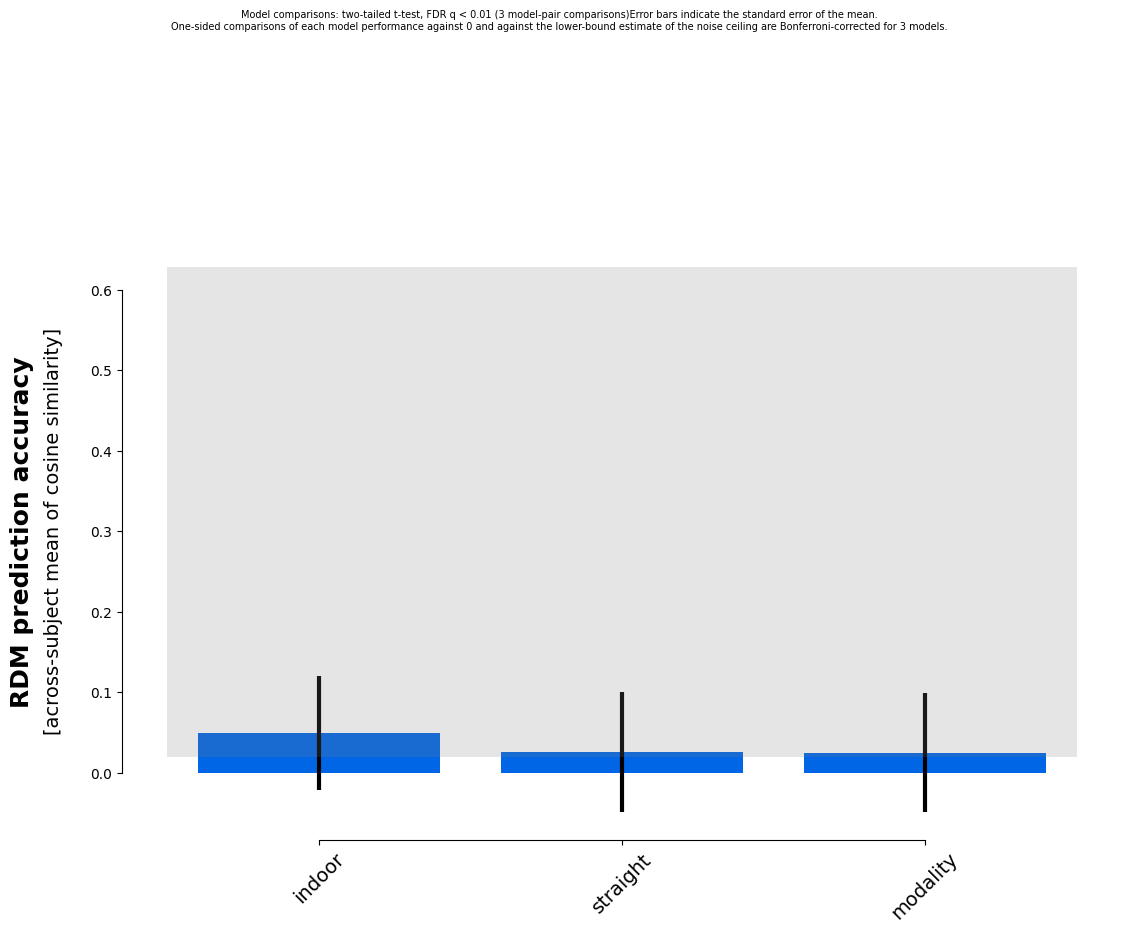

In [39]:
from rsatoolbox.vis.model_plot import plot_model_comparison

fig, _, _ = plot_model_comparison(eval_result, sort=True)
matplotlib.pyplot.show()